In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [2]:
# Load the MNIST dataset
transform = transforms.ToTensor()

train_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=2
)

In [3]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = x.view(-1, 784)
        latent = self.encoder(x)
        mu, log_var = latent[:, :latent_dim], latent[:, latent_dim:]
        z = self.reparameterize(mu, log_var)
        reconstructed = self.decoder(z)
        return reconstructed, mu, log_var


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 10  # Dimensionality of the latent space
epochs = 20
batch_size = 128



model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def loss_function(reconstructed, x, mu, log_var):
    reconstruction_loss = nn.functional.binary_cross_entropy(reconstructed, x.view(-1, 784), reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence

def train_epoch(epoch):
    model.train()
    train_loss = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)

        optimizer.zero_grad()
        reconstructed, mu, log_var = model(data)
        loss = loss_function(reconstructed, data, mu, log_var)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f"Epoch {epoch}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item() / len(data):.4f}")

    print(f"Epoch {epoch}, Average Loss: {train_loss / len(train_loader.dataset):.4f}")

# Train the model
for epoch in range(epochs):
    train_epoch(epoch)


Epoch 0, Batch 0/469, Loss: 543.7628
Epoch 0, Batch 100/469, Loss: 305.0846
Epoch 0, Batch 200/469, Loss: 283.6670
Epoch 0, Batch 300/469, Loss: 287.1628
Epoch 0, Batch 400/469, Loss: 267.8576
Epoch 0, Average Loss: 298.8270
Epoch 1, Batch 0/469, Loss: 281.9788
Epoch 1, Batch 100/469, Loss: 260.8710
Epoch 1, Batch 200/469, Loss: 261.6942
Epoch 1, Batch 300/469, Loss: 261.2574
Epoch 1, Batch 400/469, Loss: 257.7576
Epoch 1, Average Loss: 260.4260
Epoch 2, Batch 0/469, Loss: 254.8357
Epoch 2, Batch 100/469, Loss: 246.4852
Epoch 2, Batch 200/469, Loss: 261.1157
Epoch 2, Batch 300/469, Loss: 248.5186
Epoch 2, Batch 400/469, Loss: 249.1737
Epoch 2, Average Loss: 253.6424
Epoch 3, Batch 0/469, Loss: 248.3493
Epoch 3, Batch 100/469, Loss: 262.6652
Epoch 3, Batch 200/469, Loss: 259.0901
Epoch 3, Batch 300/469, Loss: 254.1499
Epoch 3, Batch 400/469, Loss: 256.1468
Epoch 3, Average Loss: 249.6442
Epoch 4, Batch 0/469, Loss: 255.3473
Epoch 4, Batch 100/469, Loss: 263.5406
Epoch 4, Batch 200/469, 

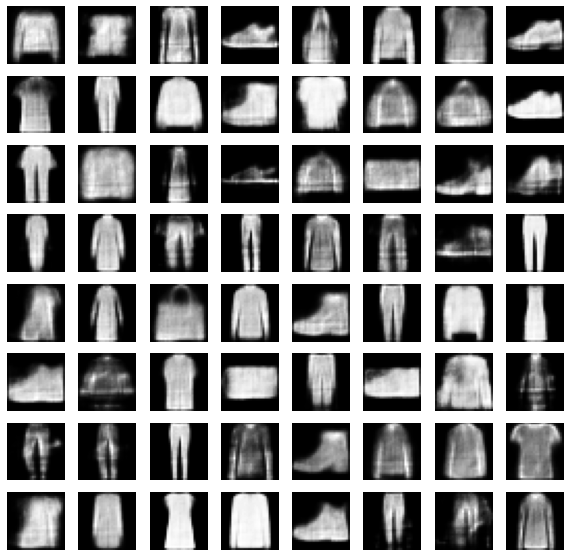

In [5]:
def generate_images():
    model.eval()

    with torch.no_grad():
        latent_samples = torch.randn(64, latent_dim).to(device)
        generated = model.decoder(latent_samples).cpu()

    # Plot the generated images
    fig, axes = plt.subplots(8, 8, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated[i].view(28, 28), cmap='gray')
        ax.axis('off')

    plt.show()

# Generate and plot images
generate_images()
